## This one is in development - shows TensorBoard
Doesn't currently work.


In [1]:
from __future__ import print_function
%matplotlib inline 

import os
from collections import namedtuple
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from helper_functions import *

Struct = namedtuple('FLAGS', 'learning_rate log_dir dropout max_steps') 
dir_path = os.path.abspath('')

FLAGS = Struct(log_dir=os.path.join(dir_path,'logs'), dropout=0.5, \
               max_steps=15000, learning_rate=1e-4)

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
    
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.

    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations

class Number_Data():
    def __init__(self, data, filter_type='original'):
        self._index_in_epoch = 0
        self._epochs_completed = 0        
        self._x_data, self._y_data = collect_images(data, filter_type)                
        target = np.zeros((len(self._y_data), 10))
        target[np.arange(len(self._y_data)),self._y_data] = 1
        self._y_data = target
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self._x_data,self._y_data,random_state=42)
        self._num_examples = len(self.x_train)
        self.train_data_count = len(self.x_train)
        self.test_data_count = len(self.x_test)
        
        # Flatten training images.
        n_samples = len(self.x_train)
        self.x_train = self.x_train.reshape((n_samples,-1))
        n_samples = len(self.x_test)
        self.x_test = self.x_test.reshape((n_samples,-1))        
        
        # Get flattened test images.
        self.test_images = self.test_images()
        self.test_labels = self.y_test
        
        if tf.gfile.Exists(FLAGS.log_dir):
            tf.gfile.DeleteRecursively(FLAGS.log_dir)
        tf.gfile.MakeDirs(FLAGS.log_dir)
        
    def train(self):
        sess = tf.InteractiveSession()
        
        # Initialize input and target tensors.
        with tf.name_scope('input'):
            x = tf.placeholder(tf.float32, shape=[None, 784],name='x-input')
            y_ = tf.placeholder(tf.float32, shape=[None, 10],name='y-input')

        # Initialize weight and bias tensors.
        with tf.name_scope('convolutional_layer_1'):
            W_conv1 = weight_variable([5, 5, 1, 32])            
            b_conv1 = bias_variable([32])
        with tf.name_scope('input_reshape'):
            x_image = tf.reshape(x, [-1,28,28,1])
            tf.summary.image('input', x_image, 10)
            
        with tf.name_scope('convolutional_layer1'):
            h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
            
        with tf.name_scope('pooling_layer_1'):
            h_pool1 = max_pool_2x2(h_conv1)
        
        with tf.name_scope('convolutional_layer_2'):
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])        
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        
        with tf.name_scope('pooling_layer_2'):
            h_pool2 = max_pool_2x2(h_conv2)
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])            
        
        h_fc1 = nn_layer(h_pool2_flat, 7*7*64, 512, 'fully_connected_layer_1')
        print(h_fc1,h_pool2_flat,h_pool2)
        
        with tf.name_scope('dropout'):
            keep_prob = tf.placeholder(tf.float32)
            tf.summary.scalar('dropout_keep_probability', keep_prob)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)        

#         with tf.name_scope('fully_connected_layer_2'):        
#             W_fc2 = weight_variable([512, 10])
#             b_fc2 = bias_variable([10])

        y_conv = nn_layer(h_fc1_drop, 512, 10, 'fully_connected_layer_2')
#         y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
                
        with tf.name_scope('cross_entropy'):
            # The raw formulation of cross-entropy,
            #
            # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
            #                               reduction_indices=[1]))
            #
            # can be numerically unstable.
            #
            # So here we use tf.nn.softmax_cross_entropy_with_logits on the
            # raw outputs of the nn_layer above, and then average across
            # the batch.
            diff = tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
            with tf.name_scope('total'):
                cross_entropy = tf.reduce_mean(diff)

        tf.summary.scalar('cross_entropy', cross_entropy)

        with tf.name_scope('train'):
            train_step = tf.train.AdamOptimizer(FLAGS.learning_rate).minimize(cross_entropy)
#         cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, self.y_))
        with tf.name_scope('accuracy'):
            with tf.name_scope('correct_prediction'):
                correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
            with tf.name_scope('accuracy'):
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
        # Merge all the summaries and write them out to /logs
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(FLAGS.log_dir + '/train',
                                      sess.graph)
        test_writer = tf.summary.FileWriter(FLAGS.log_dir + '/test')
        tf.global_variables_initializer().run()
        
        # Train the model, and also write summaries.
        # Every 10th step, measure test-set accuracy, and write test summaries
        # All other steps, run train_step on training data, & add training summaries

        def feed_dict(train):
            """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
            if train:
                xs, ys = self.next_batch(300)
                k = FLAGS.dropout
            else:
                xs, ys = self.test_images, self.test_labels
                k = 1.0
            return {x: xs, y_: ys, keep_prob: k}
    
        for i in range(FLAGS.max_steps):
#             batch = self.next_batch(300)  
            if i % 10 == 0:  # Record summaries and test-set accuracy                
                summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
                test_writer.add_summary(summary, i)
                print('Accuracy at step %s: %s' % (i, acc))
            else:  # Record train set summaries, and train
                if i % 100 == 99:  # Record execution stats
#                     run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#                     run_metadata = tf.RunMetadata()
                    summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
#                     train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
                    train_writer.add_summary(summary, i)
                    print('Adding run metadata for', i)
                else:
                    summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                    train_writer.add_summary(summary, i)
        train_writer.close()
        test_writer.close()
        
#         correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(self.y_,1))
#         self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#         sess.run(tf.global_variables_initializer())
    
    def next_batch(self, batch_size=100, shuffle=True):
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._images = self.x_train[perm0]
            self._labels = self.y_train[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self.x_train[start:self._num_examples]
            labels_rest_part = self.y_train[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._images = self._images[perm]
                self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            images_new_part = self._images[start:end]
            labels_new_part = self._labels[start:end]
            return np.concatenate((images_rest_part, images_new_part), axis=0) , np.concatenate((labels_rest_part, labels_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch            
            return self._images[start:end], self._labels[start:end]
        
    def test_images(self):
        images = self.x_test
        n_samples = len(images)
        return images.reshape((n_samples, -1))

#     def train_network(self):
#         for i in range(20000):
#             batch = self.next_batch(100)    
#             if i%100 == 0:
#                 train_accuracy = self.accuracy.eval(feed_dict={self.x:batch[0], self.y_: batch[1], self.keep_prob: 1.0})
#                 print("step %d, training accuracy %g"%(i, train_accuracy))
#             self.train_step.run(feed_dict={self.x: batch[0], self.y_: batch[1], self.keep_prob: 0.5})

#         print("test accuracy %g"%self.accuracy.eval(feed_dict={
#             self.x: self.test_images, self.y_: self.test_labels, self.keep_prob: 1.0}))

data = pickle.load(open('data3_4.p', 'rb'))
number_data = Number_Data(data, 'original')

In [2]:
number_data.train()

Tensor("fully_connected_layer_1/activation:0", shape=(?, 512), dtype=float32) Tensor("pooling_layer_2/Reshape:0", shape=(?, 3136), dtype=float32) Tensor("pooling_layer_2/MaxPool:0", shape=(?, 7, 7, 64), dtype=float32)
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
Accuracy at step 0: 0.0678689
Accuracy at step 10: 0.146209
Accuracy at step 20: 0.0781462
Accuracy at step 30: 0.0781462
Accuracy at step 40: 0.0781462
Accuracy at step 50: 0.0781462
Accuracy at step 60: 0.0781462


KeyboardInterrupt: 

## The one that works

In [17]:
from __future__ import print_function

%matplotlib inline 

import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from helper_functions import *

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

class Number_Data():
    def __init__(self, data, filter_type='original'):
        self._index_in_epoch = 0
        self._epochs_completed = 0        
        self._x_data, self._y_data = collect_images(data, filter_type)                
        target = np.zeros((len(self._y_data), 10))
        target[np.arange(len(self._y_data)),self._y_data] = 1
        self._y_data = target
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self._x_data,self._y_data,random_state=42)
        self._num_examples = len(self.x_train)
        self.train_data_count = len(self.x_train)
        self.test_data_count = len(self.x_test)
        print(self.y_test[0:1])
        # Flatten training images.
        n_samples = len(self.x_train)
        self.x_train = self.x_train.reshape((n_samples,-1))
        n_samples = len(self.x_test)
        self.x_test = self.x_test.reshape((n_samples,-1))        
        
        # Get flattened test images.
        self.test_images = self.test_images()
        self.test_labels = self.y_test
        
        sess = tf.InteractiveSession()
        
        # Initialize input and target tensors.
        self.x = tf.placeholder(tf.float32, shape=[None, 784])
        self.y_ = tf.placeholder(tf.float32, shape=[None, 10])

        # Initialize weight and bias tensors.
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])

        x_image = tf.reshape(self.x, [-1,28,28,1])

        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)

        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])

        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

        W_fc1 = weight_variable([7 * 7 * 64, 512])
        b_fc1 = bias_variable([512])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        self.keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob)

        W_fc2 = weight_variable([512, 10])
        b_fc2 = bias_variable([10])

        self.y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.y_conv, self.y_))

        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(self.y_conv,1), tf.argmax(self.y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        sess.run(tf.global_variables_initializer())
    
    def __call__(self,feed_list):        
        """ Classify image. """
        
        feed_dict = {self.x : feed_list[0], self.y_: feed_list[1], self.keep_prob:feed_list[2]}
#         classification = tf.run(self.y_, feed_dict)
#         print(classification)
        sess = tf.get_default_session()
        classification = sess.run(self.y_conv, feed_dict)
        print(classification)
        train_accuracy = self.accuracy.eval(feed_dict=feed_dict)
        print("test accuracy %g"%train_accuracy)
        
    def next_batch(self, batch_size=100, shuffle=True):
        start = self._index_in_epoch
        # Shuffle for the first epoch
        if self._epochs_completed == 0 and start == 0 and shuffle:
            perm0 = np.arange(self._num_examples)
            np.random.shuffle(perm0)
            self._images = self.x_train[perm0]
            self._labels = self.y_train[perm0]
        # Go to the next epoch
        if start + batch_size > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start
            images_rest_part = self.x_train[start:self._num_examples]
            labels_rest_part = self.y_train[start:self._num_examples]
            # Shuffle the data
            if shuffle:
                perm = np.arange(self._num_examples)
                np.random.shuffle(perm)
                self._images = self._images[perm]
                self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            images_new_part = self._images[start:end]
            labels_new_part = self._labels[start:end]
            return np.concatenate((images_rest_part, images_new_part), axis=0) , np.concatenate((labels_rest_part, labels_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch            
            return self._images[start:end], self._labels[start:end]
        
    def test_images(self):
        images = self.x_test
        n_samples = len(images)
        return images.reshape((n_samples, -1))

    def train_network(self):
        for i in range(300):
            batch = self.next_batch(300)    
            if i%100 == 0:
                train_accuracy = self.accuracy.eval(feed_dict={self.x:batch[0], self.y_: batch[1], self.keep_prob: 1.0})
                print("step %d, training accuracy %g"%(i, train_accuracy))
            self.train_step.run(feed_dict={self.x: batch[0], self.y_: batch[1], self.keep_prob: 0.5})

        print("test accuracy %g"%self.accuracy.eval(feed_dict={
            self.x: self.test_images, self.y_: self.test_labels, self.keep_prob: 1.0}))
        
        for i in range(10):
            sess = tf.get_default_session()
            
            classification = sess.run(self.y_conv, feed_dict)
            print(classification)

data = pickle.load(open('data3_4.p', 'rb'))

number_data = Number_Data(data, 'original')
number_data.train_network()

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
step 0, training accuracy 0.0866667
step 100, training accuracy 0.86
step 200, training accuracy 0.936667
test accuracy 0.953073


[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]] 0
(1, 784)
[[ 172.58149719  -55.81375885  -41.54990768   63.47083664    0.55141979
     3.5224762    -9.64442444  -47.83455276   79.66389465  -38.50832748]]
test accuracy 1


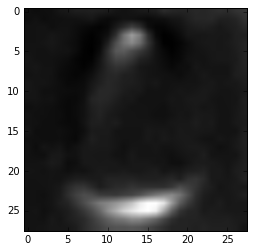

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[  0.44434917 -29.784729   -15.12847137   0.60656571  12.6217804
   -0.93256193  -9.46363735  -0.38820034 -13.06709957  35.45954132]]
test accuracy 1


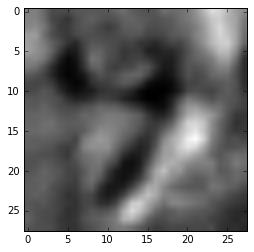

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[ -0.35496533  10.48157215 -16.00095749   2.11951184   0.92586809
    4.18841171  -9.49662971 -28.89996147 -13.31799126   8.73131657]]
test accuracy 0


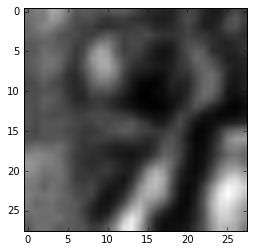

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[ 0.77801049 -5.70866489  1.48986423 -1.35477948 -0.4181959  -1.11850131
   2.60268807 -0.04617791 -2.20739055  7.65031767]]
test accuracy 1


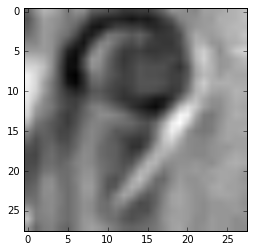

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[ -3.37306881  -2.56842422  -4.73464966  -7.59651232  -3.59081125
   -7.09180641  -5.94071245  -4.68907785   5.69535971  11.04838467]]
test accuracy 1


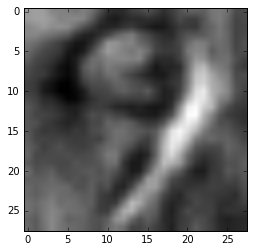

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[ -6.33457184   6.18783474  -5.46159077 -10.50101948   2.47680473
    5.85185719   3.89606237  14.51365089   9.12378597  19.37850952]]
test accuracy 1


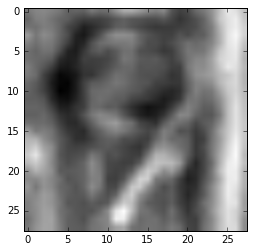

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[ -1.2960788  -13.88536453  13.55284023   1.40917468   4.4945364
  -11.36678314  -2.4270997    1.98504472   6.31160831   5.21564436]]
test accuracy 0


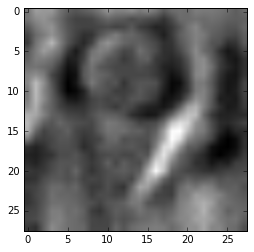

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[-4.83948278 -9.77312851  0.36792785 -7.47497463 -1.70258737  3.2150588
   0.72062051 -1.1127733   2.24359512  5.38284016]]
test accuracy 1


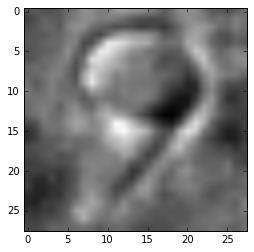

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[  5.90193987   0.81982034   0.74342412  -8.12192917 -15.5100565
   -1.24188757 -13.03723526   5.36597204  -0.31423566  13.32161522]]
test accuracy 1


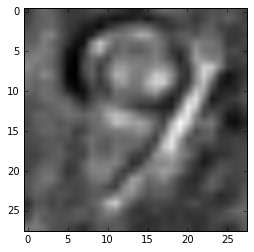

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] 9
(1, 784)
[[-28.28499794 -10.42909241 -24.90579414   2.63088727  -5.35299826
  -50.30132675  34.87195587  37.62520599 -25.46087265  47.15261078]]
test accuracy 1


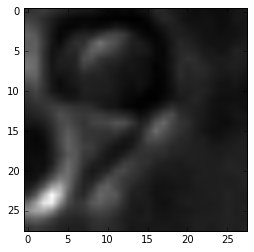

In [18]:
# Check individual image classification

for i in range(10):
    image = data['original'][-i].reshape((-1,784))
    target_number = data['targets'][-i]
    target = np.zeros((1, 10))
    target[np.arange(1),target_number] = 1    
    print(target,target_number)
    print(image.shape)    
    
    feed_list = [image, target, 1.0]
    number_data(feed_list)
    plt.imshow(image.reshape((28,28)),cmap=plt.cm.gray)
    plt.show()